# Opening Range Breakout (ORB) Strategy Implementation

This notebook implements an Opening Range Breakout trading strategy for S&P 500 (SP) and NASDAQ (NQ) futures contracts. The strategy identifies breakouts from an opening range and takes directional positions based on price movement relative to this range.

## 1. Library Imports and Configuration
- **Trading Constants**: 
  - `POINT_VALUE`: Dollar value per point move (SP: $50/point, NQ: $20/point) - used for PnL calculations
  - `TX_COST`: Transaction cost per contract ($12 per side) - models slippage and commissions

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Group 1 specs
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}
TX_COST = {"SP": 12.0, "NQ": 12.0}  # per 1 contract trade
DATA_DIR = Path("../data")

file_path = next(DATA_DIR.glob("data1_*.parquet"))  # first Group 1 parquet found
file_path

WindowsPath('../data/data1_2023_Q1.parquet')

## 2. Data Loading and Index Preparation

In [2]:
df = pd.read_parquet(file_path)

# Making sure we have datetime index
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.set_index("datetime")
else:
    df.index = pd.to_datetime(df.index)

df = df.sort_index()
df.head()

,NQ,SP
datetime,,
2023-01-02 09:31:00+00:00,NaN,NaN
2023-01-02 09:32:00+00:00,NaN,NaN
2023-01-02 09:33:00+00:00,NaN,NaN
2023-01-02 09:34:00+00:00,NaN,NaN
2023-01-02 09:35:00+00:00,NaN,NaN


## 3. Trading Rules Implementation - Time-Based Masks

**Technical Details:**
- **Mask Architecture**: Boolean arrays aligned with the DatetimeIndex for vectorized conditional operations
- **NaN Windows**: 
  - 09:31-09:40 (market open volatility)
  - 15:51-16:00 (closing auction period)
  - These periods excluded from calculations to avoid distorted metrics from thin liquidity and wide spreads
- **No-Trade Zone** (09:31-09:55): Prevents entries during the first 25 minutes when bid-ask spreads are widest and volatility is highest
- **Forced Flat** (15:40-16:00): Liquidates all positions before close to avoid overnight risk and margin requirements

In [3]:
def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Creates masks required by the assignment for Group 1:
    - NaN windows for calculations: 9:31-9:40 and 15:51-16:00
    - no trading: 9:31-9:55
    - flat from: 15:40 to end (no overnight)
    """
    t = index.time

    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close

    no_trade = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    flat_from = (t >= pd.to_datetime("15:40").time())

    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": no_trade, "mask_flat_from": flat_from},
        index=index
    )

masks = add_group1_masks(df.index)
masks.head()

,mask_nan,mask_no_trade,mask_flat_from
datetime,,,
2023-01-02 09:31:00+00:00,True,True,False
2023-01-02 09:32:00+00:00,True,True,False
2023-01-02 09:33:00+00:00,True,True,False
2023-01-02 09:34:00+00:00,True,True,False
2023-01-02 09:35:00+00:00,True,True,False


## 4. Core ORB Strategy Function

**Technical Details:**

### Input Parameters:
- `price_raw`: 1-minute price series
- `asset`: Instrument identifier (SP/NQ) for accessing contract specifications
- `range_start/range_end`: Time window defining the opening range (default: 09:41-09:55)
- `atr_window`: Lookback period for ATR calculation (volatility measure)
- `atr_mult`: ATR multiplier for breakout threshold (lower = more sensitive, more trades)
- `allow_reentry`: If False, limits to one entry per day (reduces transaction costs)

### Algorithm Flow:

1. **Data Preparation**:
   - Creates clean price series by setting NaN during excluded windows
   - Prevents biased calculations from unreliable data points

2. **ATR Calculation**:
   - Proxy for Average True Range using 1-minute absolute price changes
   - Rolling mean with minimum period threshold ensures robust estimates even with missing data
   - Adapts breakout threshold to current volatility regime

3. **Daily Loop Structure**:
   - Groups by date for day-by-day processing
   - Each day is independent (no overnight positions)

4. **Opening Range Definition**:
   - High/Low of prices during [range_start, range_end] window
   - Forms the baseline for breakout detection

5. **Entry Logic**:
   - **Long Entry**: Price > range_high + (atr_mult × ATR)
   - **Short Entry**: Price < range_low - (atr_mult × ATR)
   - ATR buffer filters false breakouts caused by noise

6. **Exit Logic**:
   - Mean reversion exit when price returns inside opening range
   - Reduces holding time and whipsaw risk

7. **Position Management**:
   - `pos_lag`: Uses previous bar's position for PnL attribution (prevents look-ahead bias)
   - Enforces no-trade and flat-from rules via mask overrides

8. **PnL Calculation**:
   - Gross PnL = position × price_change × point_value
   - Trade counting via position delta (`diff().abs()`)
   - Net PnL = Gross PnL - (trades × transaction_cost)

**Output**: DataFrame with price, position, PnL, and cost columns for downstream analysis

In [4]:
def run_orb_strategy(price_raw: pd.Series, asset: str,
                     range_start="09:41", range_end="09:55",
                     atr_window=30, atr_mult=0.1,
                     allow_reentry=False):
    """
    Opening Range Breakout (ORB):
    - Build range using [range_start, range_end] (inclusive).
    - After range_end: go long if price > range_high + atr_mult*ATR
                      go short if price < range_low  - atr_mult*ATR
    - allow_reentry=False => at most one entry per day.
    - Forced flat by rules: no trade 9:31-9:55; flat from 15:40.
    """
    out = pd.DataFrame(index=price_raw.index)
    out["price_raw"] = price_raw

    global masks
    if "masks" not in globals() or not masks.index.equals(out.index):
        masks = add_group1_masks(out.index)

    # Clean price for calculations (NaN windows)
    out["price_clean"] = out["price_raw"].where(~masks["mask_nan"], np.nan)

    # ATR proxy for 1-minute series: rolling mean of absolute price changes
    out["atr"] = out["price_clean"].diff().abs().rolling(atr_window, min_periods=max(5, atr_window//3)).mean()

    # Day key
    out["date"] = out.index.date
    out["time"] = out.index.strftime("%H:%M")

    pos = np.zeros(len(out), dtype=np.int8)

    pv = POINT_VALUE[asset]
    cost = TX_COST[asset]

    # Looping day-by-day
    for d, day in out.groupby("date"):
        day_idx = day.index

        # Determining opening range on this day
        in_range = (day["time"] >= range_start) & (day["time"] <= range_end)
        rng_prices = day.loc[in_range, "price_clean"].dropna()

        if rng_prices.empty:
            continue

        range_high = float(rng_prices.max())
        range_low  = float(rng_prices.min())

        # We only trade after range_end
        tradable = day["time"] > range_end

        entered_today = False
        current_pos = 0

        # Iterating through bars in that day
        for i_local, ts in enumerate(day_idx):
            # force flat windows
            if masks.loc[ts, "mask_no_trade"] or masks.loc[ts, "mask_flat_from"]:
                current_pos = 0
                pos[out.index.get_loc(ts)] = 0
                continue

            if not tradable.loc[ts]:
                # before range_end => no position
                current_pos = 0
                pos[out.index.get_loc(ts)] = 0
                continue

            px = day.loc[ts, "price_clean"]
            atr = day.loc[ts, "atr"]

            # If price/atr missing, we just hold whatever we have (usually 0)
            if not np.isfinite(px) or not np.isfinite(atr):
                pos[out.index.get_loc(ts)] = current_pos
                continue

            upper = range_high + atr_mult * atr
            lower = range_low  - atr_mult * atr

            if current_pos == 0:
                # entry
                if (not entered_today) or allow_reentry:
                    if px > upper:
                        current_pos = 1
                        entered_today = True
                    elif px < lower:
                        current_pos = -1
                        entered_today = True

            else:
                # exit rule: optional simple exit when price returns inside range (keeps trades low)
                if range_low <= px <= range_high:
                    current_pos = 0

            pos[out.index.get_loc(ts)] = current_pos

    out["position"] = pos

    # PnL
    dp = out["price_clean"].diff()
    pos_lag = out["position"].shift(1).fillna(0).astype(int)

    out["gross_pnl"] = pos_lag * dp * pv

    out["trades"] = out["position"].diff().abs().fillna(0).astype(int)
    out["costs"] = out["trades"] * cost
    out["net_pnl"] = out["gross_pnl"] - out["costs"]

    return out

## 5. Intraday to Daily Aggregation

**Technical Details:**
- **Temporal Aggregation**: Converts 1-minute intraday results to daily frequency
- **Date Grouping**: Extracts date component from datetime index for groupby operation
- **Sum Aggregation**: Daily PnL is the sum of all intraday bar PnLs (additive property of returns)
- **Trade Counting**: Total trades per day helps monitor turnover and cost burden

In [5]:
def daily_from_intraday(res: pd.DataFrame) -> pd.DataFrame:
    daily = res[["gross_pnl", "net_pnl", "trades"]].copy()
    daily["date"] = daily.index.date
    return daily.groupby("date").sum(numeric_only=True)

## 6. Performance Metrics Functions

**Technical Details:**

### Maximum Drawdown (MDD):
- **Definition**: Largest peak-to-trough decline in cumulative PnL
- **Calculation**: `cummax()` tracks running maximum, drawdown is current level minus running max
- **Interpretation**: Risk measure indicating worst historical loss from a peak
- Returns negative value or zero

### Annualized Sharpe Ratio:
- **Formula**: (Mean Daily PnL / Std Dev Daily PnL) × √252
- **Assumptions**: 252 trading days per year (standard for US equity futures)
- **Interpretation**: Risk-adjusted return metric (>1.0 is good, >2.0 is excellent)
- **Denominator Check**: Handles zero std dev edge case (constant returns)
- Uses `ddof=1` for sample standard deviation (unbiased estimator)

### Annualized Calmar Ratio:
- **Formula**: Annualized Return / |Max Drawdown|
- **Relationship**: Return per unit of drawdown risk
- **Interpretation**: Higher is better; complements Sharpe by focusing on tail risk
- Returns `np.nan` if MDD is zero (no drawdown scenario)

### Quarter Summary Function:
- Computes all metrics for both gross and net PnL
- **Custom STAT Metric**: 
  - Formula: (Net Sharpe - 0.5) × ln(|Net PnL / 1000|)
  - Penalizes low Sharpe (threshold = 0.5)
  - Rewards larger absolute PnL (log scaling prevents domination by single outlier)
  - Used as optimization objective for parameter tuning
- **Average Trades**: Monitors turnover intensity (higher = more costs)

In [6]:
def max_drawdown(cum: pd.Series) -> float:
    dd = cum - cum.cummax()
    return float(dd.min()) if len(dd) else 0.0

def ann_sharpe(x: pd.Series) -> float:
    sd = float(x.std(ddof=1))
    if sd == 0 or not np.isfinite(sd):
        return np.nan
    return float(x.mean() / sd * np.sqrt(252))

def ann_calmar(x: pd.Series) -> float:
    cum = x.cumsum()
    mdd = max_drawdown(cum)  # negative or 0
    if mdd == 0:
        return np.nan
    ann = float(x.mean() * 252)
    return float(ann / abs(mdd))

def summarize_quarter(daily: pd.DataFrame) -> dict:
    gross = daily["gross_pnl"]
    net = daily["net_pnl"]

    gross_sr = ann_sharpe(gross)
    net_sr = ann_sharpe(net)

    gross_cr = ann_calmar(gross)
    net_cr = ann_calmar(net)

    gross_cum = float(gross.cumsum().iloc[-1]) if len(gross) else 0.0
    net_cum = float(net.cumsum().iloc[-1]) if len(net) else 0.0

    av_ntrades = float(daily["trades"].mean()) if len(daily) else 0.0

    # required stat
    net_pnl_1000 = net_cum / 1000.0
    log_term = max(0.0, float(np.log(abs(net_pnl_1000)))) if abs(net_pnl_1000) > 0 else 0.0
    stat = (float(net_sr) - 0.5) * log_term if np.isfinite(net_sr) else np.nan

    return {
        "grossSR": gross_sr,
        "netSR": net_sr,
        "grossCR": gross_cr,
        "netCR": net_cr,
        "gross_cumPnL": gross_cum,
        "net_cumPnL": net_cum,
        "av.ntrades": av_ntrades,
        "stat": stat,
    }

## 7. Initial Backtest Across All Quarters

**Technical Details:**

### Initial Parameters:
- Starting with baseline parameters (30-bar ATR, 0.10 multiplier, no reentry)
- Same parameters for both assets initially (later optimized separately)

### Processing Loop:
1. **File Iteration**: Processes each quarter's Parquet file in sorted order
2. **Per-Quarter Operations**:
   - Recomputes masks for the specific quarter's datetime index
   - Runs strategy separately for SP and NQ
   - Aggregates daily results
   
3. **Portfolio Construction**:
   - Union of SP and NQ date indices (handles days where only one asset traded)
   - `reindex()` with `fill_value=0` handles missing dates
   - Element-wise addition of aligned series

4. **Output Generation**:
   - Per-asset summaries: Used for strategy selection and parameter optimization
   - Portfolio summary: Aggregated performance for reporting
   - Daily CSV files: Granular data for time series visualization

5. **Results Table**:
   - Rows contain: quarter identifier, asset, parameters, and all computed metrics
   - Enables cross-quarter and cross-asset performance comparison

In [7]:
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("outputs_orb")
OUTPUT_DIR.mkdir(exist_ok=True)

# ORB params (simple base hyperparameters)
ORB_PARAMS = {
    "SP": {"atr_window": 30, "atr_mult": 0.10, "allow_reentry": False},
    "NQ": {"atr_window": 30, "atr_mult": 0.10, "allow_reentry": False},
}

rows = []

for fp in sorted(DATA_DIR.glob("data1_*.parquet")):
    dfq = pd.read_parquet(fp)
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    dfq = dfq.sort_index()

    # recomputing masks for this quarter
    masks = add_group1_masks(dfq.index)

    quarter = fp.stem
    print("Running ORB:", quarter)

    res_sp = run_orb_strategy(dfq["SP"], "SP", **ORB_PARAMS["SP"])
    res_nq = run_orb_strategy(dfq["NQ"], "NQ", **ORB_PARAMS["NQ"])

    daily_sp = daily_from_intraday(res_sp)
    daily_nq = daily_from_intraday(res_nq)

    # portfolio aggregation
    daily_port = pd.DataFrame(index=daily_sp.index.union(daily_nq.index)).fillna(0)
    daily_port["gross_pnl"] = daily_sp["gross_pnl"].reindex(daily_port.index, fill_value=0) + daily_nq["gross_pnl"].reindex(daily_port.index, fill_value=0)
    daily_port["net_pnl"]   = daily_sp["net_pnl"].reindex(daily_port.index, fill_value=0)   + daily_nq["net_pnl"].reindex(daily_port.index, fill_value=0)
    daily_port["trades"]    = daily_sp["trades"].reindex(daily_port.index, fill_value=0)    + daily_nq["trades"].reindex(daily_port.index, fill_value=0)

    # per-asset summaries
    rows.append({"quarter": quarter, "asset": "SP", **ORB_PARAMS["SP"], **summarize_quarter(daily_sp)})
    rows.append({"quarter": quarter, "asset": "NQ", **ORB_PARAMS["NQ"], **summarize_quarter(daily_nq)})

    # portfolio summary
    rows.append({"quarter": quarter, "asset": "PORT", **summarize_quarter(daily_port)})

    daily_port.reset_index(names="date").to_csv(OUTPUT_DIR / f"{quarter}_portfolio_daily.csv", index=False)

orb_summary = pd.DataFrame(rows)
orb_summary.to_csv(OUTPUT_DIR / "orb_summary.csv", index=False)

orb_summary

Running ORB: data1_2023_Q1
Running ORB: data1_2023_Q3
Running ORB: data1_2023_Q4
Running ORB: data1_2024_Q2
Running ORB: data1_2024_Q4
Running ORB: data1_2025_Q1
Running ORB: data1_2025_Q2


,quarter,asset,atr_window,atr_mult,allow_reentry,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades,stat
0,data1_2023_Q1,SP,30.0,0.1,False,2.108688,1.736568,7.545329,5.894581,8633.90,7109.90,1.969231,2.425513
1,data1_2023_Q1,NQ,30.0,0.1,False,-1.254330,-1.549630,-1.539834,-1.770459,-6523.48,-8059.48,1.969231,-4.277269
2,data1_2023_Q1,PORT,NaN,NaN,NaN,0.331839,-0.149311,0.791723,-0.311903,2110.42,-949.58,3.938462,-0.000000
3,data1_2023_Q3,SP,30.0,0.1,False,0.440179,-0.172161,0.910202,-0.335142,1086.90,-425.10,1.938462,-0.000000
4,data1_2023_Q3,NQ,30.0,0.1,False,3.489707,3.206870,31.639834,26.306204,18629.76,17117.76,1.938462,7.687826
5,data1_2023_Q3,PORT,NaN,NaN,NaN,3.096192,2.621775,20.535077,14.259655,19716.66,16692.66,3.876923,5.972732
6,data1_2023_Q4,SP,30.0,0.1,False,-2.125176,-3.522612,-3.775390,-4.040819,-2335.90,-3871.90,2.000000,-5.445593
7,data1_2023_Q4,NQ,30.0,0.1,False,0.857824,0.326544,2.008514,0.677605,2480.08,944.08,2.000000,-0.000000
8,data1_2023_Q4,PORT,NaN,NaN,NaN,0.042611,-0.865281,0.110300,-1.802715,144.18,-2927.82,4.000000,-1.466664
9,data1_2024_Q2,SP,30.0,0.1,False,1.507496,0.955020,7.615461,3.394109,4256.65,2696.65,2.000000,0.451385


## 8. Parameter Optimization - Grid Search

**Technical Details:**

- **TRAINING SET** (4 quarters): 2023_Q1, 2023_Q3, 2024_Q2, 2024_Q4
  - ~57% of available data
- **VALIDATION SET** (2 quarters): 2023_Q4, 2025_Q1
  - ~29% of available data
- **OUT-OF-SAMPLE TEST** (1 quarter): 2025_Q2
  - ~14% of available data

### Scoring Function (`orb_score_for_asset`):
- Runs strategy across all in-sample quarters with given parameters
- Accumulates total STAT score and net PnL across quarters
- Optimizes on sum of quarterly STATs (not overall STAT)

### Two-Stage Grid Search:
1. **Stage 1 - Training**: Run all parameter combinations on TRAIN quarters
   - Compute STAT scores on training data
2. **Stage 2 - Validation**: Evaluate same parameters on VALIDATION quarters
   - Select best parameters based on validation performance
   - This prevents selecting parameters that overfit to training data

### Grid Search Space:
- **ATR Windows**: [15, 30, 60] minutes
  - Shorter = more responsive to recent volatility
  - Longer = more stable, less parameter sensitivity
- **ATR Multipliers**: [0.0, 0.05, 0.10, 0.15, 0.20]
  - 0.0 = no buffer (immediate breakout)
  - Higher values = stricter filter (fewer false breakouts, fewer trades)
- Total: 3 × 5 × 2 assets = 30 combinations
- SP and NQ optimized independently (different volatility characteristics)- Sorted by asset and STAT score (descending)

### Asset-Specific Optimization:

- SP and NQ optimized independently (different volatility characteristics)
- Allows strategy to adapt to each contract's microstructure### Output Table:- Sorted by VALIDATION performance (not training!)

- Allows strategy to adapt to each contract's microstructure
- Shows top-30 parameter combinations

In [8]:
# 3-WAY SPLIT FOR HYPERPARAMETER TUNING

# TRAIN 
TRAIN_TAGS = ["2023_Q1", "2023_Q3", "2024_Q2", "2024_Q4"]
train_files = [fp for fp in sorted(DATA_DIR.glob("data1_*.parquet")) if any(tag in fp.stem for tag in TRAIN_TAGS)]

# VALIDATION: Used to SELECT best parameters (prevents overfitting to train)
VALIDATION_TAGS = ["2023_Q4", "2025_Q1"]  # 2 quarters
validation_files = [fp for fp in sorted(DATA_DIR.glob("data1_*.parquet")) if any(tag in fp.stem for tag in VALIDATION_TAGS)]

# OUT-OF-SAMPLE TEST: Final evaluation ONLY (completely untouched during optimization)
TEST_TAGS = ["2025_Q2"]  # 1 quarter
test_files = [fp for fp in sorted(DATA_DIR.glob("data1_*.parquet")) if any(tag in fp.stem for tag in TEST_TAGS)]

print(f"Training quarters: {len(train_files)} - {TRAIN_TAGS}")
print(f"Validation quarters: {len(validation_files)} - {VALIDATION_TAGS}")
print(f"Test quarters: {len(test_files)} - {TEST_TAGS}")

def orb_score_for_asset(asset, atr_window, atr_mult, files):
    """Score a parameter combination across multiple quarters"""
    total_stat = 0.0
    total_net = 0.0

    for fp in files:
        dfq = pd.read_parquet(fp)
        if "datetime" in dfq.columns:
            dfq["datetime"] = pd.to_datetime(dfq["datetime"])
            dfq = dfq.set_index("datetime")
        else:
            dfq.index = pd.to_datetime(dfq.index)
        dfq = dfq.sort_index()

        global masks
        masks = add_group1_masks(dfq.index)

        res = run_orb_strategy(dfq[asset], asset, atr_window=atr_window, atr_mult=atr_mult, allow_reentry=False)
        daily = daily_from_intraday(res)
        summ = summarize_quarter(daily)

        total_stat += summ["stat"]
        total_net += summ["net_cumPnL"]

    return total_stat, total_net

# Grid search parameters
atr_windows = [15, 30, 60]
atr_mults = [0.0, 0.05, 0.10, 0.15, 0.20]

# Running all parameter combinations on TRAINING data
print("\nStep 1: Running grid search on TRAINING data...")
train_rows = []
for asset in ["SP", "NQ"]:
    for w in atr_windows:
        for m in atr_mults:
            score, net = orb_score_for_asset(asset, w, m, train_files)
            train_rows.append({"asset": asset, "atr_window": w, "atr_mult": m, 
                             "train_stat": score, "train_net": net})

train_results = pd.DataFrame(train_rows)

# Evaluating same parameters on VALIDATION data to select best
print("\nStep 2: Evaluating on VALIDATION data for parameter selection...")
val_rows = []
for asset in ["SP", "NQ"]:
    for w in atr_windows:
        for m in atr_mults:
            score, net = orb_score_for_asset(asset, w, m, validation_files)
            val_rows.append({"asset": asset, "atr_window": w, "atr_mult": m, 
                           "val_stat": score, "val_net": net})

val_results = pd.DataFrame(val_rows)

# Merging and selecting best parameters based on VALIDATION performance
tune_orb = train_results.merge(val_results, on=["asset", "atr_window", "atr_mult"])
tune_orb = tune_orb.sort_values(["asset", "val_stat"], ascending=[True, False])

print("\nTop 30 parameter combinations by VALIDATION performance:")
tune_orb.head(30)

Training quarters: 4 - ['2023_Q1', '2023_Q3', '2024_Q2', '2024_Q4']
Validation quarters: 2 - ['2023_Q4', '2025_Q1']
Test quarters: 1 - ['2025_Q2']

Step 1: Running grid search on TRAINING data...

Step 2: Evaluating on VALIDATION data for parameter selection...

Top 30 parameter combinations by VALIDATION performance:


,asset,atr_window,atr_mult,train_stat,train_net,val_stat,val_net
24,NQ,30,0.20,4.394956,16601.00,2.856703,12866.76
19,NQ,15,0.20,5.433614,18159.70,1.709631,10828.96
27,NQ,60,0.10,1.037763,7922.20,0.497950,6870.22
28,NQ,60,0.15,1.438792,9238.74,0.419698,5497.64
29,NQ,60,0.20,5.840139,19611.24,0.419698,5432.44
15,NQ,15,0.00,-7.498986,3976.94,0.402319,6706.36
20,NQ,30,0.00,-7.498986,3976.94,0.402319,6706.36
25,NQ,60,0.00,-8.184190,3030.94,0.343953,6493.44
16,NQ,15,0.05,-7.404246,4126.64,0.318028,6304.06
21,NQ,30,0.05,1.763302,8872.32,0.318028,6304.06


## 9. Extracting Best Parameters per Asset

In [9]:
# Selecting best parameters based on Validation performance
best_per_asset = tune_orb.sort_values("val_stat", ascending=False).groupby("asset").head(1)
best_per_asset

,asset,atr_window,atr_mult,train_stat,train_net,val_stat,val_net
24,NQ,30,0.2,4.394956,16601.0,2.856703,12866.76
0,SP,15,0.0,5.220507,14151.8,-0.365383,7017.70


## 10. Isolating Best Parameters

In [10]:
# Extracting best parameters based on Validation performance
best_nq = tune_orb[tune_orb["asset"] == "NQ"].sort_values("val_stat", ascending=False).iloc[0]
best_sp = tune_orb[tune_orb["asset"] == "SP"].sort_values("val_stat", ascending=False).iloc[0]

print("Best SP parameters (selected on VALIDATION):")
print(f"  ATR Window: {best_sp['atr_window']}, ATR Mult: {best_sp['atr_mult']}")
print(f"  Train STAT: {best_sp['train_stat']:.4f}, Val STAT: {best_sp['val_stat']:.4f}")

print("\nBest NQ parameters (selected on VALIDATION):")
print(f"  ATR Window: {best_nq['atr_window']}, ATR Mult: {best_nq['atr_mult']}")
print(f"  Train STAT: {best_nq['train_stat']:.4f}, Val STAT: {best_nq['val_stat']:.4f}")

best_sp, best_nq

Best SP parameters (selected on VALIDATION):
  ATR Window: 15, ATR Mult: 0.0
  Train STAT: 5.2205, Val STAT: -0.3654

Best NQ parameters (selected on VALIDATION):
  ATR Window: 30, ATR Mult: 0.2
  Train STAT: 4.3950, Val STAT: 2.8567


(asset               SP
 atr_window          15
 atr_mult           0.0
 train_stat    5.220507
 train_net      14151.8
 val_stat     -0.365383
 val_net         7017.7
 Name: 0, dtype: object,
 asset               NQ
 atr_window          30
 atr_mult           0.2
 train_stat    4.394956
 train_net      16601.0
 val_stat      2.856703
 val_net       12866.76
 Name: 24, dtype: object)

## 11. Constructing Final Parameter Dictionary

In [11]:
ORB_PARAMS_FINAL = {
    "SP": {"atr_window": int(best_sp["atr_window"]), "atr_mult": float(best_sp["atr_mult"]), "allow_reentry": False},
    "NQ": {"atr_window": int(best_nq["atr_window"]), "atr_mult": float(best_nq["atr_mult"]), "allow_reentry": False},
}
ORB_PARAMS_FINAL

{'SP': {'atr_window': 15, 'atr_mult': 0.0, 'allow_reentry': False},
 'NQ': {'atr_window': 30, 'atr_mult': 0.2, 'allow_reentry': False}}

## 12. Final Backtest with Optimized Parameters

### Backtest on ALL Quarters (Train + Test)

This section runs the optimized parameters on:
- **Training quarters** (2023_Q1, Q3, Q4, 2024_Q2, Q4) - Expected to perform well
- **Test quarters** (2025_Q1, Q2) - TRUE out-of-sample validation

### Critical Files Generated:
1. **Daily Portfolio CSVs**: Time series for visualization
2. **orb_final_summary.csv**: Complete performance table with quarter-by-quarter breakdown

### Key Validation:
- Compare training vs test performance to assess overfitting

- Test quarters should show degradation (if not, parameters are robust)- Large performance gap indicates overfitting to training data

In [12]:
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("outputs_orb_final")
OUTPUT_DIR.mkdir(exist_ok=True)

rows = []

for fp in sorted(DATA_DIR.glob("data1_*.parquet")):
    dfq = pd.read_parquet(fp)
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    dfq = dfq.sort_index()

    masks = add_group1_masks(dfq.index)
    quarter = fp.stem
    print("FINAL ORB:", quarter)

    res_sp = run_orb_strategy(dfq["SP"], "SP", **ORB_PARAMS_FINAL["SP"])
    res_nq = run_orb_strategy(dfq["NQ"], "NQ", **ORB_PARAMS_FINAL["NQ"])

    daily_sp = daily_from_intraday(res_sp)
    daily_nq = daily_from_intraday(res_nq)

    # Portfolio daily aggregation
    daily_port = pd.DataFrame(index=daily_sp.index.union(daily_nq.index)).fillna(0)
    daily_port["gross_pnl"] = daily_sp["gross_pnl"].reindex(daily_port.index, fill_value=0) + daily_nq["gross_pnl"].reindex(daily_port.index, fill_value=0)
    daily_port["net_pnl"]   = daily_sp["net_pnl"].reindex(daily_port.index, fill_value=0)   + daily_nq["net_pnl"].reindex(daily_port.index, fill_value=0)
    daily_port["trades"]    = daily_sp["trades"].reindex(daily_port.index, fill_value=0)    + daily_nq["trades"].reindex(daily_port.index, fill_value=0)

    # Saving daily portfolio series for plots later
    daily_port.reset_index(names="date").to_csv(OUTPUT_DIR / f"{quarter}_portfolio_daily.csv", index=False)

    # Saving per-quarter summaries
    rows.append({"quarter": quarter, "asset": "SP", **ORB_PARAMS_FINAL["SP"], **summarize_quarter(daily_sp)})
    rows.append({"quarter": quarter, "asset": "NQ", **ORB_PARAMS_FINAL["NQ"], **summarize_quarter(daily_nq)})
    rows.append({"quarter": quarter, "asset": "PORTFOLIO", **summarize_quarter(daily_port)})

final_summary = pd.DataFrame(rows)
final_summary.to_csv(OUTPUT_DIR / "orb_final_summary.csv", index=False)

final_summary


FINAL ORB: data1_2023_Q1
FINAL ORB: data1_2023_Q3
FINAL ORB: data1_2023_Q4
FINAL ORB: data1_2024_Q2
FINAL ORB: data1_2024_Q4
FINAL ORB: data1_2025_Q1
FINAL ORB: data1_2025_Q2


,quarter,asset,atr_window,atr_mult,allow_reentry,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades,stat
0,data1_2023_Q1,SP,15.0,0.0,False,2.218354,1.845532,7.922513,6.252406,9065.50,7541.50,1.969231,2.718540
1,data1_2023_Q1,NQ,30.0,0.2,False,-1.374360,-1.669458,-1.649481,-1.867721,-7152.48,-8688.48,1.969231,-4.690364
2,data1_2023_Q1,PORTFOLIO,NaN,NaN,NaN,0.300831,-0.180369,0.700790,-0.370772,1913.02,-1146.98,3.938462,-0.093301
3,data1_2023_Q3,SP,15.0,0.0,False,0.463609,-0.148813,0.956044,-0.288948,1144.60,-367.40,1.938462,-0.000000
4,data1_2023_Q3,NQ,30.0,0.2,False,3.478636,3.195416,31.294280,26.024440,18545.76,17033.76,1.938462,7.642037
5,data1_2023_Q3,PORTFOLIO,NaN,NaN,NaN,3.098269,2.622901,19.988168,13.940014,19690.36,16666.36,3.876923,5.972552
6,data1_2023_Q4,SP,15.0,0.0,False,-2.070791,-3.468608,-3.627295,-4.042500,-2275.50,-3811.50,2.000000,-5.310089
7,data1_2023_Q4,NQ,30.0,0.2,False,1.986804,1.570722,5.550350,3.918093,7334.44,5798.44,2.000000,1.881889
8,data1_2023_Q4,PORTFOLIO,NaN,NaN,NaN,1.253518,0.492329,3.607273,1.155614,5058.94,1986.94,4.000000,-0.005267
9,data1_2024_Q2,SP,15.0,0.0,False,1.685906,1.132592,8.968822,4.756519,4753.20,3193.20,2.000000,0.734454


## 13. Train / Validation / Test Performance Analysis

In [13]:
# Splitting results into TRAIN / VALIDATION / TEST sets
portfolio_results = final_summary[final_summary["asset"] == "PORTFOLIO"].copy()

train_quarters_list = ["data1_2023_Q1", "data1_2023_Q3", "data1_2024_Q2", "data1_2024_Q4"]
validation_quarters_list = ["data1_2023_Q4", "data1_2025_Q1"]
test_quarters_list = ["data1_2025_Q2"]

train_res = portfolio_results[portfolio_results["quarter"].isin(train_quarters_list)]
val_res = portfolio_results[portfolio_results["quarter"].isin(validation_quarters_list)]
test_res = portfolio_results[portfolio_results["quarter"].isin(test_quarters_list)]

# Calculating metrics for each set
train_metrics = {
    "Net PnL": train_res["net_cumPnL"].sum(),
    "Avg Sharpe": train_res["netSR"].mean(),
    "Avg Calmar": train_res["netCR"].mean(),
    "STAT Sum": train_res["stat"].sum(),
    "Quarters": len(train_res)
}

val_metrics = {
    "Net PnL": val_res["net_cumPnL"].sum(),
    "Avg Sharpe": val_res["netSR"].mean(),
    "Avg Calmar": val_res["netCR"].mean(),
    "STAT Sum": val_res["stat"].sum(),
    "Quarters": len(val_res)
}

test_metrics = {
    "Net PnL": test_res["net_cumPnL"].sum(),
    "Avg Sharpe": test_res["netSR"].mean(),
    "Avg Calmar": test_res["netCR"].mean(),
    "STAT Sum": test_res["stat"].sum(),
    "Quarters": len(test_res)
}

comparison_df = pd.DataFrame({
    "Training": train_metrics,
    "Validation": val_metrics,
    "Test (OOS)": test_metrics
})

print("\n" + "="*80)
print("TRAIN / VALIDATION / TEST PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string())


TRAIN / VALIDATION / TEST PERFORMANCE COMPARISON
                Training    Validation    Test (OOS)
Net PnL     30752.800000  19884.460000  20317.280000
Avg Sharpe      1.249313      1.091401      1.830403
Avg Calmar      5.299133      2.628251      8.626571
STAT Sum        9.214595      3.428845      4.006472
Quarters        4.000000      2.000000      1.000000


In [14]:
overall_stat = final_summary.loc[final_summary["asset"] == "PORTFOLIO", "stat"].sum()
overall_netpnl = final_summary.loc[final_summary["asset"] == "PORTFOLIO", "net_cumPnL"].sum()

print(f"Overall STAT Score (All Quarters): {overall_stat:.4f}")
print(f"Overall Net PnL (All Quarters): ${overall_netpnl:,.2f}")

Overall STAT Score (All Quarters): 16.6499
Overall Net PnL (All Quarters): $70,954.54


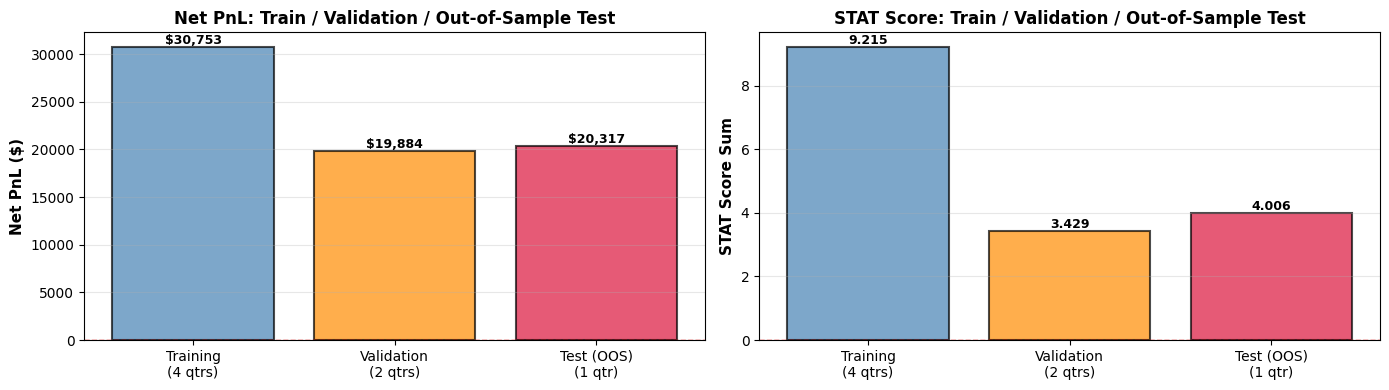


Visualization saved to: outputs_orb_final/train_val_test.png


In [15]:
# Visualize train / validation / test performance
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Panel 1: Net PnL comparison
ax1 = axes[0]
sets = ['Training\n(4 qtrs)', 'Validation\n(2 qtrs)', 'Test (OOS)\n(1 qtr)']
pnls = [train_metrics["Net PnL"], val_metrics["Net PnL"], test_metrics["Net PnL"]]
colors = ['steelblue', 'darkorange', 'crimson']
bars = ax1.bar(sets, pnls, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(0, color='red', linestyle='--', linewidth=1)
ax1.set_ylabel('Net PnL ($)', fontsize=11, fontweight='bold')
ax1.set_title('Net PnL: Train / Validation / Out-of-Sample Test', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, pnl in zip(bars, pnls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:,.0f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

# Panel 2: STAT Score comparison  
ax2 = axes[1]
stats = [train_metrics["STAT Sum"], val_metrics["STAT Sum"], test_metrics["STAT Sum"]]
bars = ax2.bar(sets, stats, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_ylabel('STAT Score Sum', fontsize=11, fontweight='bold')
ax2.set_title('STAT Score: Train / Validation / Out-of-Sample Test', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, stat in zip(bars, stats):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{stat:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig("outputs_orb_final/train_val_test.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: outputs_orb_final/train_val_test.png")

## 14. Portfolio Performance Visualization

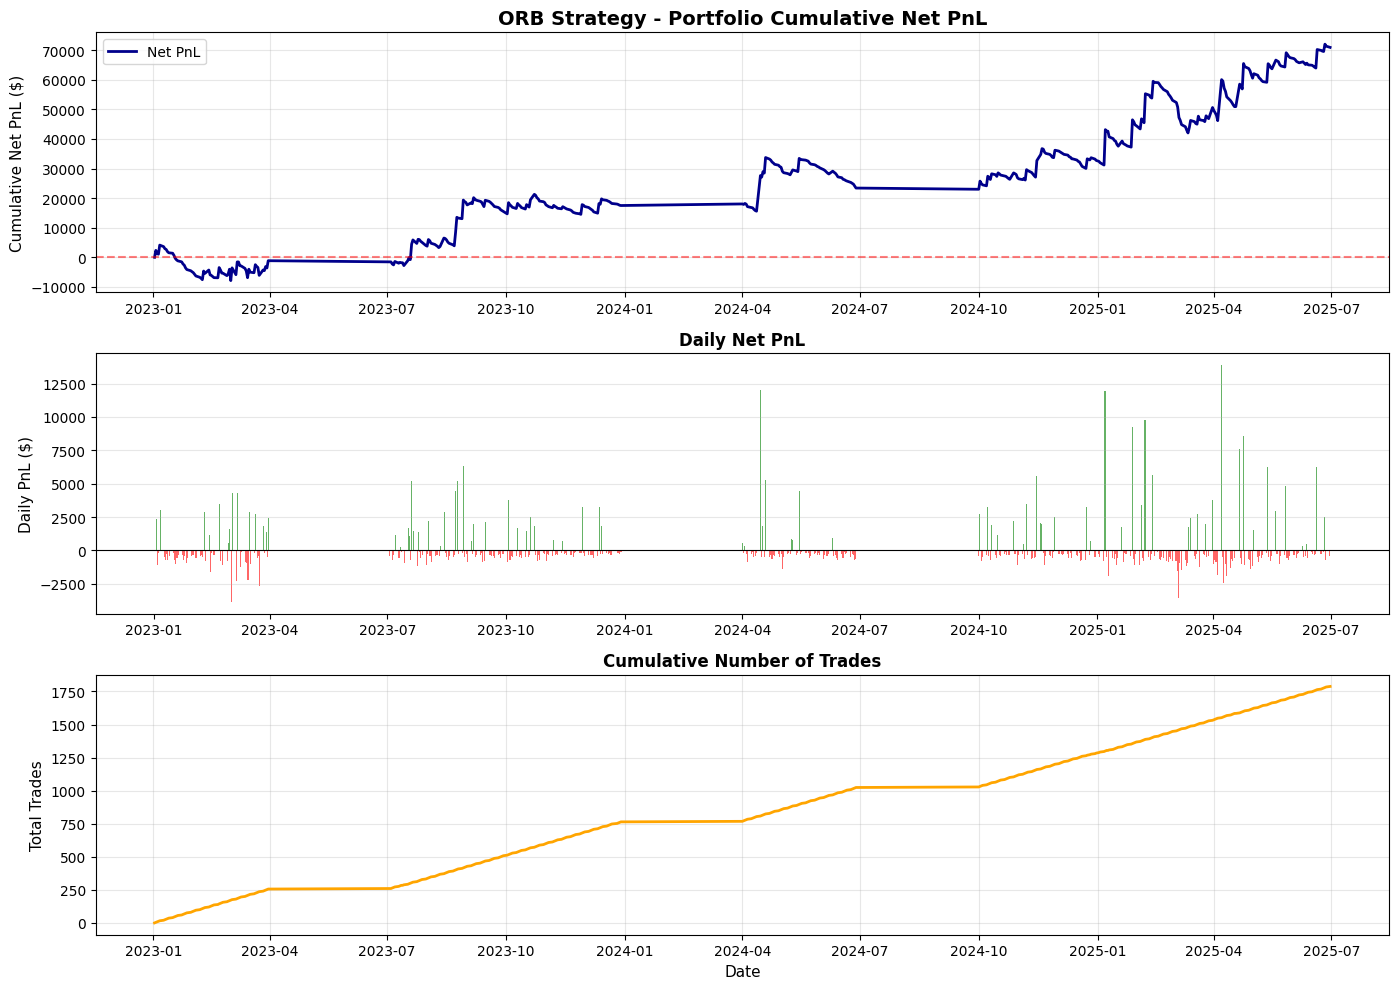


Plot saved to: outputs_orb_final/portfolio_performance.png


In [16]:
all_daily = []
for fp in sorted((Path("outputs_orb_final")).glob("*_portfolio_daily.csv")):
    daily = pd.read_csv(fp)
    daily["date"] = pd.to_datetime(daily["date"])
    daily["quarter"] = fp.stem.replace("_portfolio_daily", "")
    all_daily.append(daily)

portfolio_full = pd.concat(all_daily, ignore_index=True).sort_values("date")
portfolio_full["cum_net_pnl"] = portfolio_full["net_pnl"].cumsum()
portfolio_full["cum_gross_pnl"] = portfolio_full["gross_pnl"].cumsum()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Cumulative Net PnL
ax1 = axes[0]
ax1.plot(portfolio_full["date"], portfolio_full["cum_net_pnl"], linewidth=2, color='darkblue', label='Net PnL')
ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
ax1.set_title("ORB Strategy - Portfolio Cumulative Net PnL", fontsize=14, fontweight='bold')
ax1.set_ylabel("Cumulative Net PnL ($)", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 2. Daily Net PnL
ax2 = axes[1]
colors = ['green' if x >= 0 else 'red' for x in portfolio_full["net_pnl"]]
ax2.bar(portfolio_full["date"], portfolio_full["net_pnl"], color=colors, alpha=0.6, width=0.8)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_title("Daily Net PnL", fontsize=12, fontweight='bold')
ax2.set_ylabel("Daily PnL ($)", fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 3. Cumulative Trades
ax3 = axes[2]
portfolio_full["cum_trades"] = portfolio_full["trades"].cumsum()
ax3.plot(portfolio_full["date"], portfolio_full["cum_trades"], linewidth=2, color='orange')
ax3.set_title("Cumulative Number of Trades", fontsize=12, fontweight='bold')
ax3.set_xlabel("Date", fontsize=11)
ax3.set_ylabel("Total Trades", fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.savefig("outputs_orb_final/portfolio_performance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: outputs_orb_final/portfolio_performance.png")

## 15. Performance Metrics Summary Table

In [17]:
# Performance Metrics Summary
portfolio_metrics = final_summary[final_summary["asset"] == "PORTFOLIO"].copy()

# Overall metrics across all quarters
total_days = len(portfolio_full)
total_net_pnl = portfolio_full["net_pnl"].sum()
total_gross_pnl = portfolio_full["gross_pnl"].sum()
total_costs = portfolio_full["costs"].sum() if "costs" in portfolio_full.columns else (total_gross_pnl - total_net_pnl)
total_trades = portfolio_full["trades"].sum()

# Calculating overall Sharpe and Calmar
overall_sharpe = ann_sharpe(portfolio_full["net_pnl"])
overall_calmar = ann_calmar(portfolio_full["net_pnl"])

# Drawdown
cum_pnl = portfolio_full["cum_net_pnl"]
max_dd = max_drawdown(cum_pnl)

metrics_summary = pd.DataFrame({
    "Metric": [
        "Total Net PnL",
        "Total Gross PnL", 
        "Total Costs",
        "Total Trades",
        "Trading Days",
        "Avg Daily PnL",
        "Win Rate (%)",
        "Annualized Sharpe Ratio",
        "Annualized Calmar Ratio",
        "Maximum Drawdown",
        "Final Cumulative PnL",
        "Overall STAT Score"
    ],
    "Value": [
        f"${total_net_pnl:,.2f}",
        f"${total_gross_pnl:,.2f}",
        f"${total_costs:,.2f}",
        f"{int(total_trades)}",
        f"{total_days}",
        f"${portfolio_full['net_pnl'].mean():,.2f}",
        f"{(portfolio_full['net_pnl'] > 0).sum() / len(portfolio_full) * 100:.1f}%",
        f"{overall_sharpe:.3f}",
        f"{overall_calmar:.3f}",
        f"${max_dd:,.2f}",
        f"${cum_pnl.iloc[-1]:,.2f}",
        f"{overall_stat:.4f}"
    ]
})

print("\n" + "="*60)
print("ORB STRATEGY - PORTFOLIO PERFORMANCE SUMMARY")
print("="*60)
print(metrics_summary.to_string(index=False))
print("="*60)

metrics_summary


ORB STRATEGY - PORTFOLIO PERFORMANCE SUMMARY
                 Metric       Value
          Total Net PnL  $70,954.54
        Total Gross PnL  $92,398.54
            Total Costs  $21,444.00
           Total Trades        1788
           Trading Days         452
          Avg Daily PnL     $156.98
           Win Rate (%)       18.6%
Annualized Sharpe Ratio       1.321
Annualized Calmar Ratio       2.266
       Maximum Drawdown $-17,457.21
   Final Cumulative PnL  $70,954.54
     Overall STAT Score     16.6499


,Metric,Value
0,Total Net PnL,"$70,954.54"
1,Total Gross PnL,"$92,398.54"
2,Total Costs,"$21,444.00"
3,Total Trades,1788
4,Trading Days,452
5,Avg Daily PnL,$156.98
6,Win Rate (%),18.6%
7,Annualized Sharpe Ratio,1.321
8,Annualized Calmar Ratio,2.266
9,Maximum Drawdown,"$-17,457.21"


## 16. Quarterly Performance Breakdown Visualization

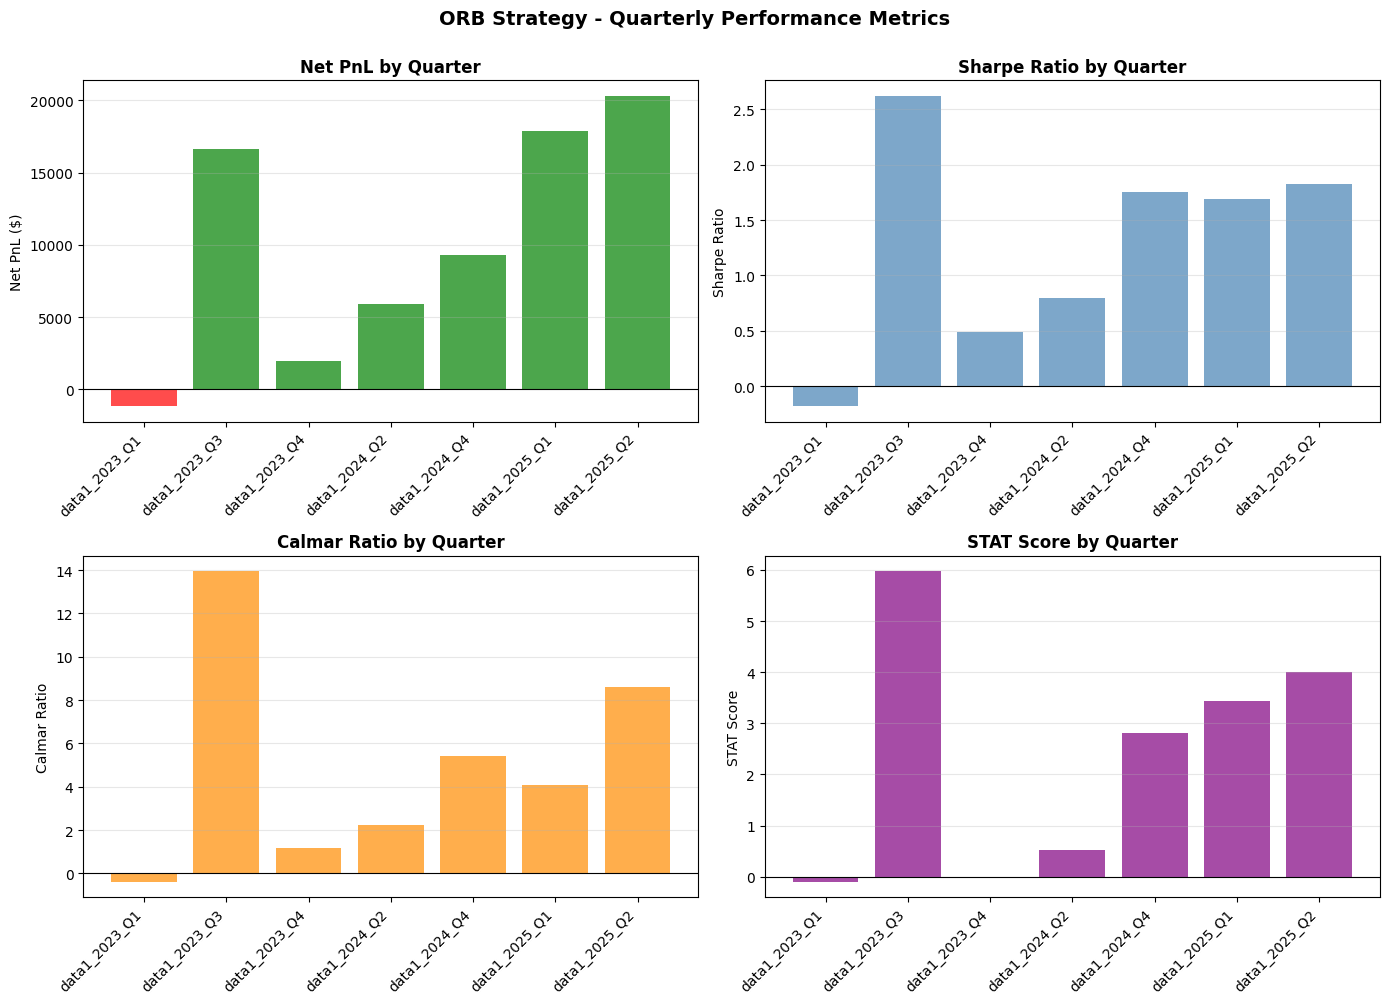


Plot saved to: outputs_orb_final/quarterly_metrics.png


In [18]:
# Quarterly Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Net PnL by Quarter
ax1 = axes[0, 0]
quarters = portfolio_metrics["quarter"].tolist()
net_pnls = portfolio_metrics["net_cumPnL"].tolist()
colors_bars = ['green' if x >= 0 else 'red' for x in net_pnls]
ax1.bar(range(len(quarters)), net_pnls, color=colors_bars, alpha=0.7)
ax1.set_xticks(range(len(quarters)))
ax1.set_xticklabels(quarters, rotation=45, ha='right')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title("Net PnL by Quarter", fontsize=12, fontweight='bold')
ax1.set_ylabel("Net PnL ($)", fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Sharpe Ratio by Quarter
ax2 = axes[0, 1]
sharpes = portfolio_metrics["netSR"].tolist()
ax2.bar(range(len(quarters)), sharpes, color='steelblue', alpha=0.7)
ax2.set_xticks(range(len(quarters)))
ax2.set_xticklabels(quarters, rotation=45, ha='right')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_title("Sharpe Ratio by Quarter", fontsize=12, fontweight='bold')
ax2.set_ylabel("Sharpe Ratio", fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Calmar Ratio by Quarter  
ax3 = axes[1, 0]
calmars = portfolio_metrics["netCR"].tolist()
ax3.bar(range(len(quarters)), calmars, color='darkorange', alpha=0.7)
ax3.set_xticks(range(len(quarters)))
ax3.set_xticklabels(quarters, rotation=45, ha='right')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title("Calmar Ratio by Quarter", fontsize=12, fontweight='bold')
ax3.set_ylabel("Calmar Ratio", fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. STAT Score by Quarter
ax4 = axes[1, 1]
stats = portfolio_metrics["stat"].tolist()
ax4.bar(range(len(quarters)), stats, color='purple', alpha=0.7)
ax4.set_xticks(range(len(quarters)))
ax4.set_xticklabels(quarters, rotation=45, ha='right')
ax4.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax4.set_title("STAT Score by Quarter", fontsize=12, fontweight='bold')
ax4.set_ylabel("STAT Score", fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle("ORB Strategy - Quarterly Performance Metrics", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("outputs_orb_final/quarterly_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: outputs_orb_final/quarterly_metrics.png")

## 17. Out-of-Sample (OOS) Evaluation on data_oos

This section evaluates the finalized ORB parameters on the newly imported OOS quarters found in `../data_oos` and writes results to `outputs_orb_oos_final`.


In [25]:
DATA_DIR_OOS = Path("../data_oos")
OUTPUT_DIR_OOS = Path("outputs_orb_oos_final")
OUTPUT_DIR_OOS.mkdir(exist_ok=True)

params_sp = {"atr_window": 30, "atr_mult": 0.10, "allow_reentry": False}
params_nq = {"atr_window": 30, "atr_mult": 0.10, "allow_reentry": False}

try:
    prev = pd.read_csv("outputs_orb_final/orb_final_summary.csv")
    prev_sp = prev[prev["asset"] == "SP"].iloc[0]
    prev_nq = prev[prev["asset"] == "NQ"].iloc[0]
    params_sp["atr_window"] = int(prev_sp.get("atr_window", params_sp["atr_window"]))
    params_sp["atr_mult"] = float(prev_sp.get("atr_mult", params_sp["atr_mult"]))
    params_nq["atr_window"] = int(prev_nq.get("atr_window", params_nq["atr_window"]))
    params_nq["atr_mult"] = float(prev_nq.get("atr_mult", params_nq["atr_mult"]))
    print("Loaded finalized params from prior results:")
    print(" SP:", params_sp)
    print(" NQ:", params_nq)
except Exception as e:
    print("Could not load prior final params; using defaults.", e)

rows_oos = []
for fp in sorted(DATA_DIR_OOS.glob("data1_*.parquet")):
    dfq = pd.read_parquet(fp)
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    dfq = dfq.sort_index()

    masks = add_group1_masks(dfq.index)
    quarter = fp.stem
    print("OOS ORB:", quarter)

    res_sp = run_orb_strategy(dfq["SP"], "SP", **params_sp)
    res_nq = run_orb_strategy(dfq["NQ"], "NQ", **params_nq)

    daily_sp = daily_from_intraday(res_sp)
    daily_nq = daily_from_intraday(res_nq)

    daily_port = pd.DataFrame(index=daily_sp.index.union(daily_nq.index)).fillna(0)
    daily_port["gross_pnl"] = daily_sp["gross_pnl"].reindex(daily_port.index, fill_value=0) + \
                               daily_nq["gross_pnl"].reindex(daily_port.index, fill_value=0)
    daily_port["net_pnl"]   = daily_sp["net_pnl"].reindex(daily_port.index, fill_value=0) + \
                               daily_nq["net_pnl"].reindex(daily_port.index, fill_value=0)
    daily_port["trades"]    = daily_sp["trades"].reindex(daily_port.index, fill_value=0) + \
                               daily_nq["trades"].reindex(daily_port.index, fill_value=0)

    rows_oos.append({"quarter": quarter, "asset": "SP", **params_sp, **summarize_quarter(daily_sp)})
    rows_oos.append({"quarter": quarter, "asset": "NQ", **params_nq, **summarize_quarter(daily_nq)})
    rows_oos.append({"quarter": quarter, "asset": "PORTFOLIO", "atr_window": np.nan, "atr_mult": np.nan, "allow_reentry": np.nan, **summarize_quarter(daily_port)})

    daily_port.reset_index(names="date").to_csv(OUTPUT_DIR_OOS / f"{quarter}_portfolio_daily.csv", index=False)

final_oos_summary = pd.DataFrame(rows_oos)
final_oos_summary.to_csv(OUTPUT_DIR_OOS / "orb_oos_final_summary.csv", index=False)

print("\n== OOS SUMMARY (PORTFOLIO) ==")
print(final_oos_summary[final_oos_summary["asset"] == "PORTFOLIO"].to_string(index=False))
final_oos_summary

Loaded finalized params from prior results:
 SP: {'atr_window': 15, 'atr_mult': 0.0, 'allow_reentry': False}
 NQ: {'atr_window': 30, 'atr_mult': 0.2, 'allow_reentry': False}
OOS ORB: data1_2023_Q2
OOS ORB: data1_2024_Q1
OOS ORB: data1_2024_Q3
OOS ORB: data1_2025_Q3
OOS ORB: data1_2025_Q4

== OOS SUMMARY (PORTFOLIO) ==
      quarter     asset  atr_window  atr_mult allow_reentry   grossSR     netSR   grossCR     netCR  gross_cumPnL  net_cumPnL  av.ntrades      stat
data1_2023_Q2 PORTFOLIO         NaN       NaN           NaN  1.056061  0.694720  3.493108  2.000165       8590.35     5650.35      3.8750  0.337200
data1_2024_Q1 PORTFOLIO         NaN       NaN           NaN  1.350755  0.604422  6.880734  2.472467       5472.80     2448.80      3.9375  0.093520
data1_2024_Q3 PORTFOLIO         NaN       NaN           NaN  0.365646 -0.093264  0.821622 -0.175163       2524.17     -643.83      4.0000 -0.000000
data1_2025_Q3 PORTFOLIO         NaN       NaN           NaN -1.877072 -2.876398 -2.75177

,quarter,asset,atr_window,atr_mult,allow_reentry,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades,stat
0,data1_2023_Q2,SP,15.0,0.0,False,0.320843,-0.116442,1.125007,-0.393246,1074.15,-389.85,1.93750,-0.000000
1,data1_2023_Q2,NQ,30.0,0.2,False,1.103839,0.887159,3.244159,2.393032,7516.20,6040.20,1.93750,0.696281
2,data1_2023_Q2,PORTFOLIO,NaN,NaN,NaN,1.056061,0.694720,3.493108,2.000165,8590.35,5650.35,3.87500,0.337200
3,data1_2024_Q1,SP,15.0,0.0,False,-0.804108,-2.292458,-1.226054,-2.666373,-816.70,-2328.70,1.96875,-2.360494
4,data1_2024_Q1,NQ,30.0,0.2,False,1.885852,1.432561,11.693695,8.108085,6289.50,4777.50,1.96875,1.458448
5,data1_2024_Q1,PORTFOLIO,NaN,NaN,NaN,1.350755,0.604422,6.880734,2.472467,5472.80,2448.80,3.93750,0.093520
6,data1_2024_Q3,SP,15.0,0.0,False,1.845734,1.363488,8.335134,5.535477,6062.55,4478.55,2.00000,1.294626
7,data1_2024_Q3,NQ,30.0,0.2,False,-0.654521,-0.947526,-0.924542,-1.240620,-3538.38,-5122.38,2.00000,-2.364706
8,data1_2024_Q3,PORTFOLIO,NaN,NaN,NaN,0.365646,-0.093264,0.821622,-0.175163,2524.17,-643.83,4.00000,-0.000000
9,data1_2025_Q3,SP,15.0,0.0,False,0.744145,0.195811,1.540046,0.379600,2149.65,565.65,2.00000,-0.000000


## 18. Out-of-Sample Performance Metrics and Visualization


In [26]:
# OOS Portfolio Results
oos_portfolio_results = final_oos_summary[final_oos_summary["asset"] == "PORTFOLIO"].copy()

print("\n" + "="*80)
print("OOS (OUT-OF-SAMPLE) PORTFOLIO PERFORMANCE SUMMARY")
print("="*80)
print(oos_portfolio_results[["quarter", "net_cumPnL", "netSR", "netCR", "av.ntrades", "stat"]].to_string(index=False))
print("="*80)

# Calculate OOS aggregate metrics
oos_net_pnl = oos_portfolio_results["net_cumPnL"].sum()
oos_sharpe = oos_portfolio_results["netSR"].mean()
oos_calmar = oos_portfolio_results["netCR"].mean()
oos_stat = oos_portfolio_results["stat"].sum()

print(f"\nOOS TOTALS:")
print(f"  Total Net PnL: ${oos_net_pnl:,.2f}")
print(f"  Average Sharpe Ratio: {oos_sharpe:.3f}")
print(f"  Average Calmar Ratio: {oos_calmar:.3f}")
print(f"  Total STAT Score: {oos_stat:.4f}")
print(f"  Number of Quarters: {len(oos_portfolio_results)}")



OOS (OUT-OF-SAMPLE) PORTFOLIO PERFORMANCE SUMMARY
      quarter  net_cumPnL     netSR     netCR  av.ntrades      stat
data1_2023_Q2     5650.35  0.694720  2.000165      3.8750  0.337200
data1_2024_Q1     2448.80  0.604422  2.472467      3.9375  0.093520
data1_2024_Q3     -643.83 -0.093264 -0.175163      4.0000 -0.000000
data1_2025_Q3    -9118.57 -2.876398 -3.073307      4.0000 -7.462897
data1_2025_Q4     7881.86  2.306503 13.256341      4.0000  3.729641

OOS TOTALS:
  Total Net PnL: $6,218.61
  Average Sharpe Ratio: 0.127
  Average Calmar Ratio: 2.896
  Total STAT Score: -3.3025
  Number of Quarters: 5


## 19. Training/Validation/Test/OOS Performance Comparison Visualization

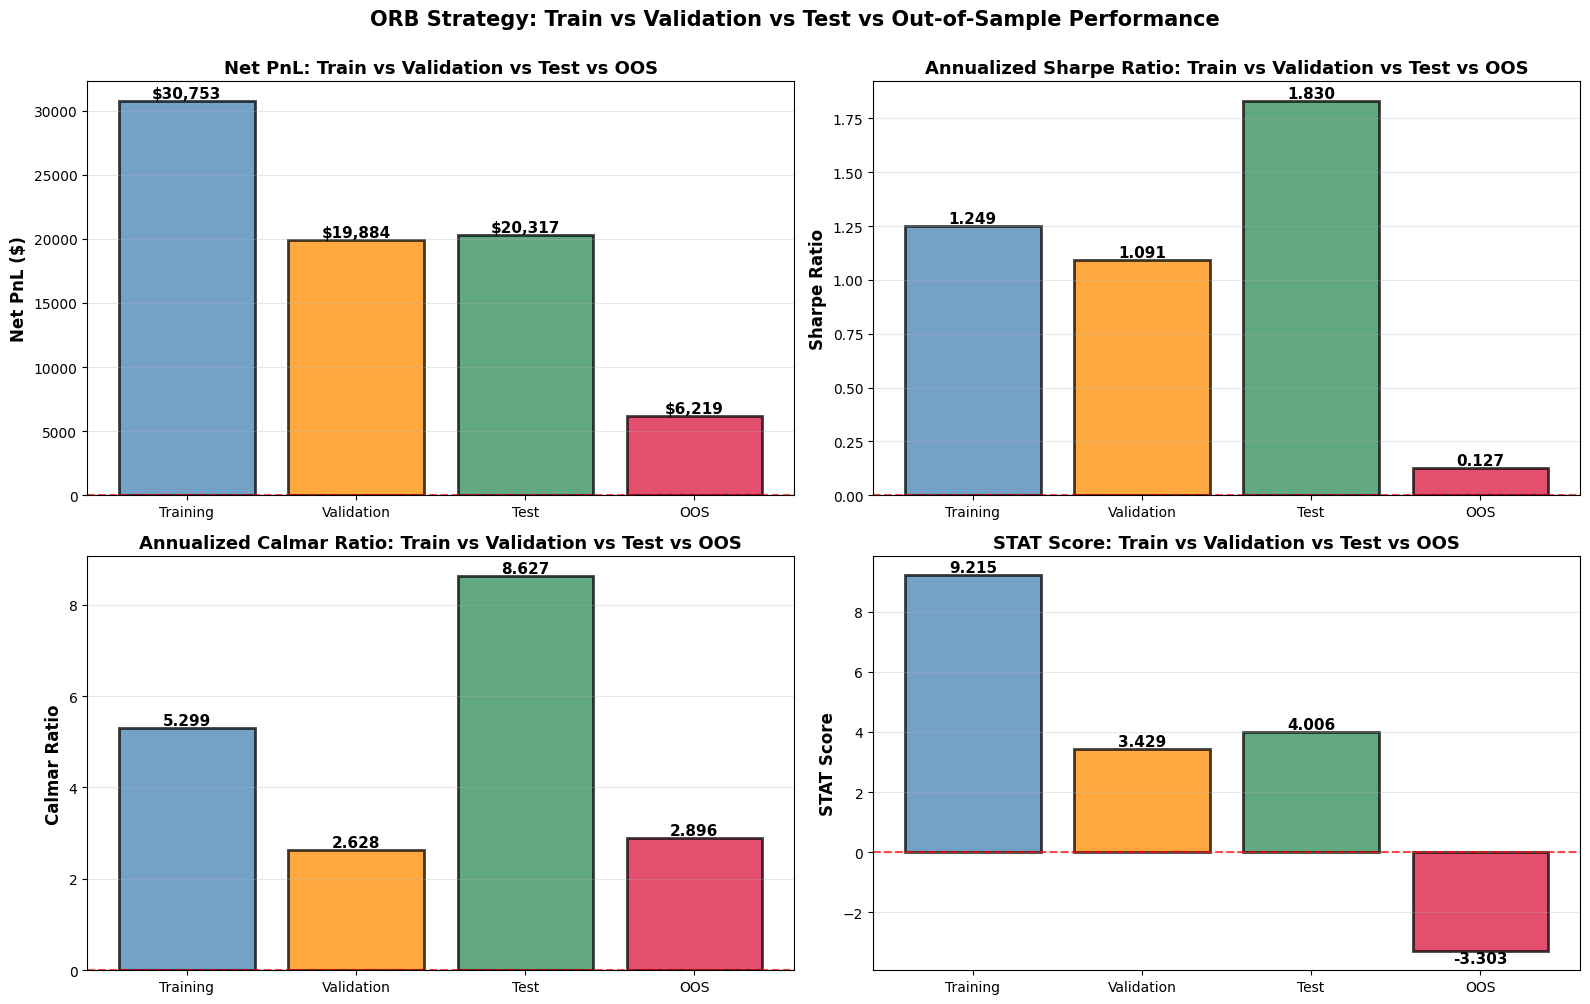


Visualization saved to: outputs_orb_oos_final/train_val_test_oos_comparison.png


In [27]:
# Comprehensive comparison: Train vs Validation vs Test vs OOS
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Panel 1: Net PnL Comparison
ax1 = axes[0, 0]
categories = ['Training', 'Validation', 'Test', 'OOS']
pnls = [train_metrics["Net PnL"], val_metrics["Net PnL"], test_metrics["Net PnL"], oos_net_pnl]
colors_pnl = ['steelblue', 'darkorange', 'seagreen', 'crimson']
bars1 = ax1.bar(categories, pnls, color=colors_pnl, alpha=0.75, edgecolor='black', linewidth=2)
ax1.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_ylabel('Net PnL ($)', fontsize=12, fontweight='bold')
ax1.set_title('Net PnL: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, pnl in zip(bars1, pnls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:,.0f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=11)

# Panel 2: Sharpe Ratio Comparison
ax2 = axes[0, 1]
sharpes = [train_metrics["Avg Sharpe"], val_metrics["Avg Sharpe"], test_metrics["Avg Sharpe"], oos_sharpe]
bars2 = ax2.bar(categories, sharpes, color=colors_pnl, alpha=0.75, edgecolor='black', linewidth=2)
ax2.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax2.set_title('Annualized Sharpe Ratio: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, sharpe in zip(bars2, sharpes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{sharpe:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=11)

# Panel 3: Calmar Ratio Comparison
ax3 = axes[1, 0]
calmars = [train_metrics["Avg Calmar"], val_metrics["Avg Calmar"], test_metrics["Avg Calmar"], oos_calmar]
bars3 = ax3.bar(categories, calmars, color=colors_pnl, alpha=0.75, edgecolor='black', linewidth=2)
ax3.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_ylabel('Calmar Ratio', fontsize=12, fontweight='bold')
ax3.set_title('Annualized Calmar Ratio: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, calmar in zip(bars3, calmars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{calmar:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=11)

# Panel 4: STAT Score Comparison
ax4 = axes[1, 1]
stats_comp = [train_metrics["STAT Sum"], val_metrics["STAT Sum"], test_metrics["STAT Sum"], oos_stat]
bars4 = ax4.bar(categories, stats_comp, color=colors_pnl, alpha=0.75, edgecolor='black', linewidth=2)
ax4.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.set_ylabel('STAT Score', fontsize=12, fontweight='bold')
ax4.set_title('STAT Score: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, stat in zip(bars4, stats_comp):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{stat:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=11)

plt.suptitle('ORB Strategy: Train vs Validation vs Test vs Out-of-Sample Performance', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("outputs_orb_oos_final/train_val_test_oos_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: outputs_orb_oos_final/train_val_test_oos_comparison.png")

## 20. OOS Daily Performance and Cumulative PnL Visualization

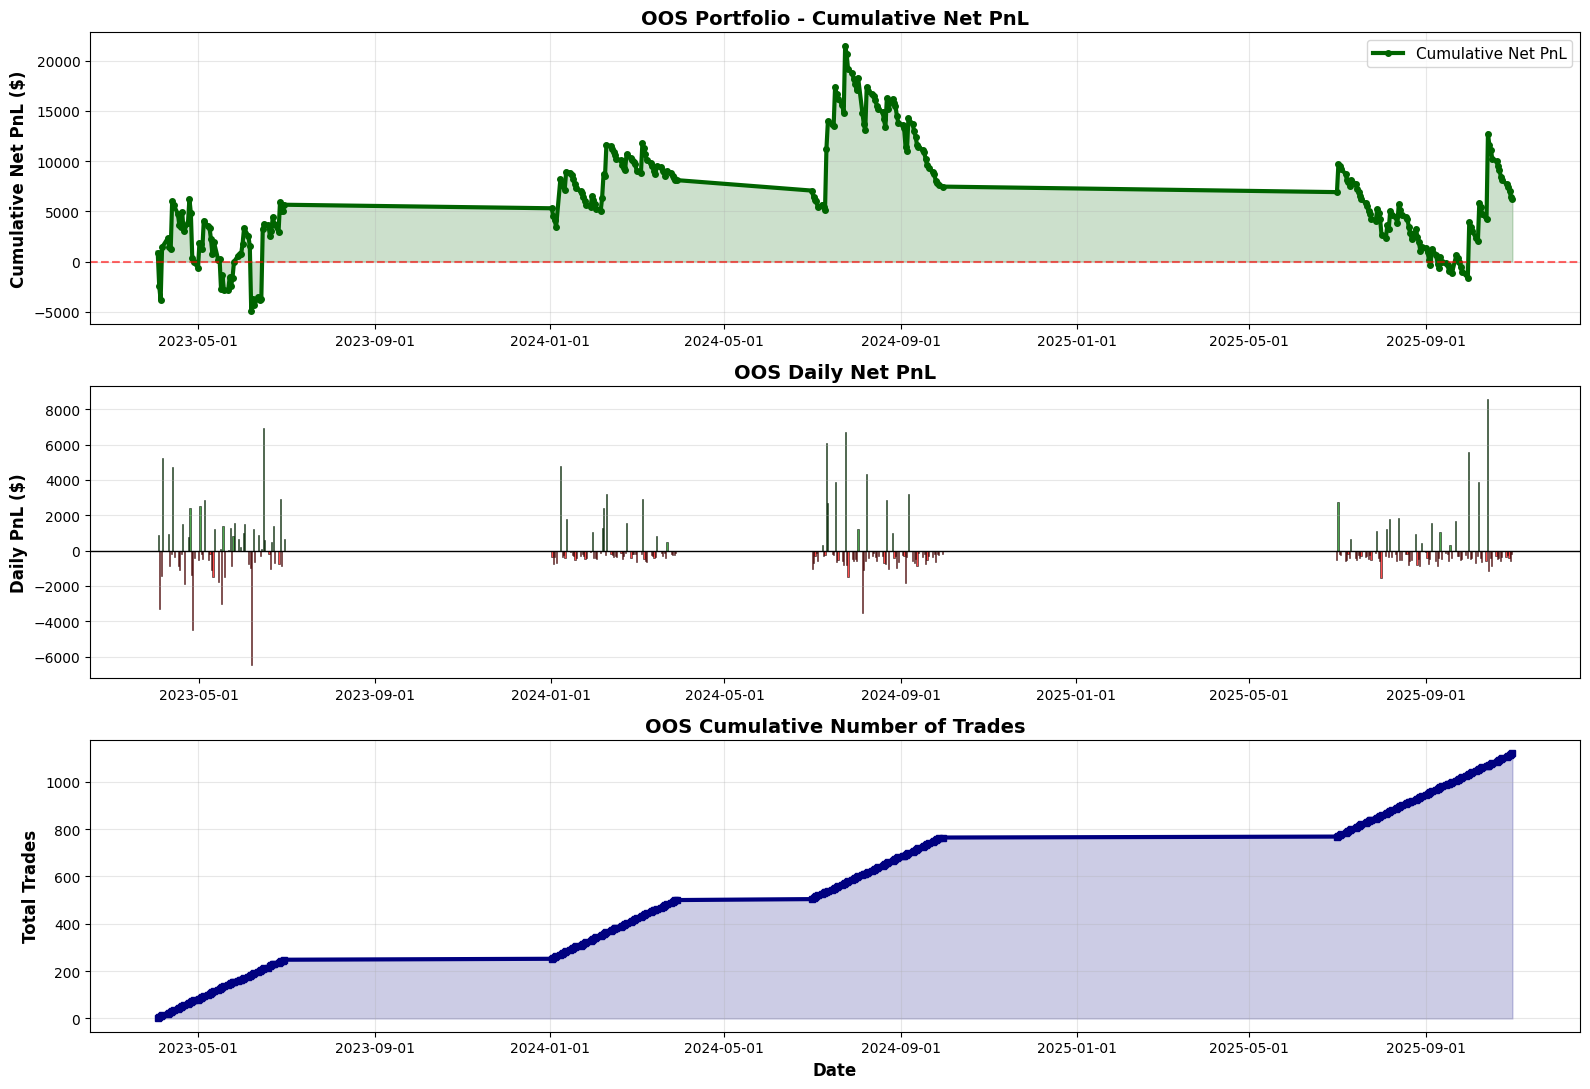

OOS portfolio visualization saved to: outputs_orb_oos_final/oos_portfolio_performance.png


In [28]:
# Consolidatind all OOS daily data
all_oos_daily = []
for fp in sorted((Path("outputs_orb_oos_final")).glob("data1_*_portfolio_daily.csv")):
    daily = pd.read_csv(fp)
    daily["date"] = pd.to_datetime(daily["date"])
    daily["quarter"] = fp.stem.replace("_portfolio_daily", "")
    all_oos_daily.append(daily)

if all_oos_daily:
    oos_portfolio_full = pd.concat(all_oos_daily, ignore_index=True).sort_values("date")
    oos_portfolio_full["cum_net_pnl"] = oos_portfolio_full["net_pnl"].cumsum()
    oos_portfolio_full["cum_gross_pnl"] = oos_portfolio_full["gross_pnl"].cumsum()

    fig, axes = plt.subplots(3, 1, figsize=(16, 11))

    # 1. Cumulative Net PnL (OOS)
    ax1 = axes[0]
    ax1.plot(oos_portfolio_full["date"], oos_portfolio_full["cum_net_pnl"], 
             linewidth=3, color='darkgreen', label='Cumulative Net PnL', marker='o', markersize=4)
    ax1.fill_between(oos_portfolio_full["date"], oos_portfolio_full["cum_net_pnl"], 
                      alpha=0.2, color='darkgreen')
    ax1.axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=1.5)
    ax1.set_title("OOS Portfolio - Cumulative Net PnL", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Cumulative Net PnL ($)", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # 2. Daily Net PnL (OOS)
    ax2 = axes[1]
    colors_daily = ['green' if x >= 0 else 'red' for x in oos_portfolio_full["net_pnl"]]
    ax2.bar(oos_portfolio_full["date"], oos_portfolio_full["net_pnl"], 
            color=colors_daily, alpha=0.7, width=0.8, edgecolor='black', linewidth=0.5)
    ax2.axhline(0, color='black', linestyle='-', linewidth=1)
    ax2.set_title("OOS Daily Net PnL", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Daily PnL ($)", fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # 3. Cumulative Trades (OOS)
    ax3 = axes[2]
    oos_portfolio_full["cum_trades"] = oos_portfolio_full["trades"].cumsum()
    ax3.plot(oos_portfolio_full["date"], oos_portfolio_full["cum_trades"], 
             linewidth=3, color='navy', marker='s', markersize=4)
    ax3.fill_between(oos_portfolio_full["date"], oos_portfolio_full["cum_trades"], 
                      alpha=0.2, color='navy')
    ax3.set_title("OOS Cumulative Number of Trades", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Date", fontsize=12, fontweight='bold')
    ax3.set_ylabel("Total Trades", fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.tight_layout()
    plt.savefig("outputs_orb_oos_final/oos_portfolio_performance.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"OOS portfolio visualization saved to: outputs_orb_oos_final/oos_portfolio_performance.png")
else:
    print("No OOS data files found.")


## 21. OOS Quarterly Performance Metrics Visualization

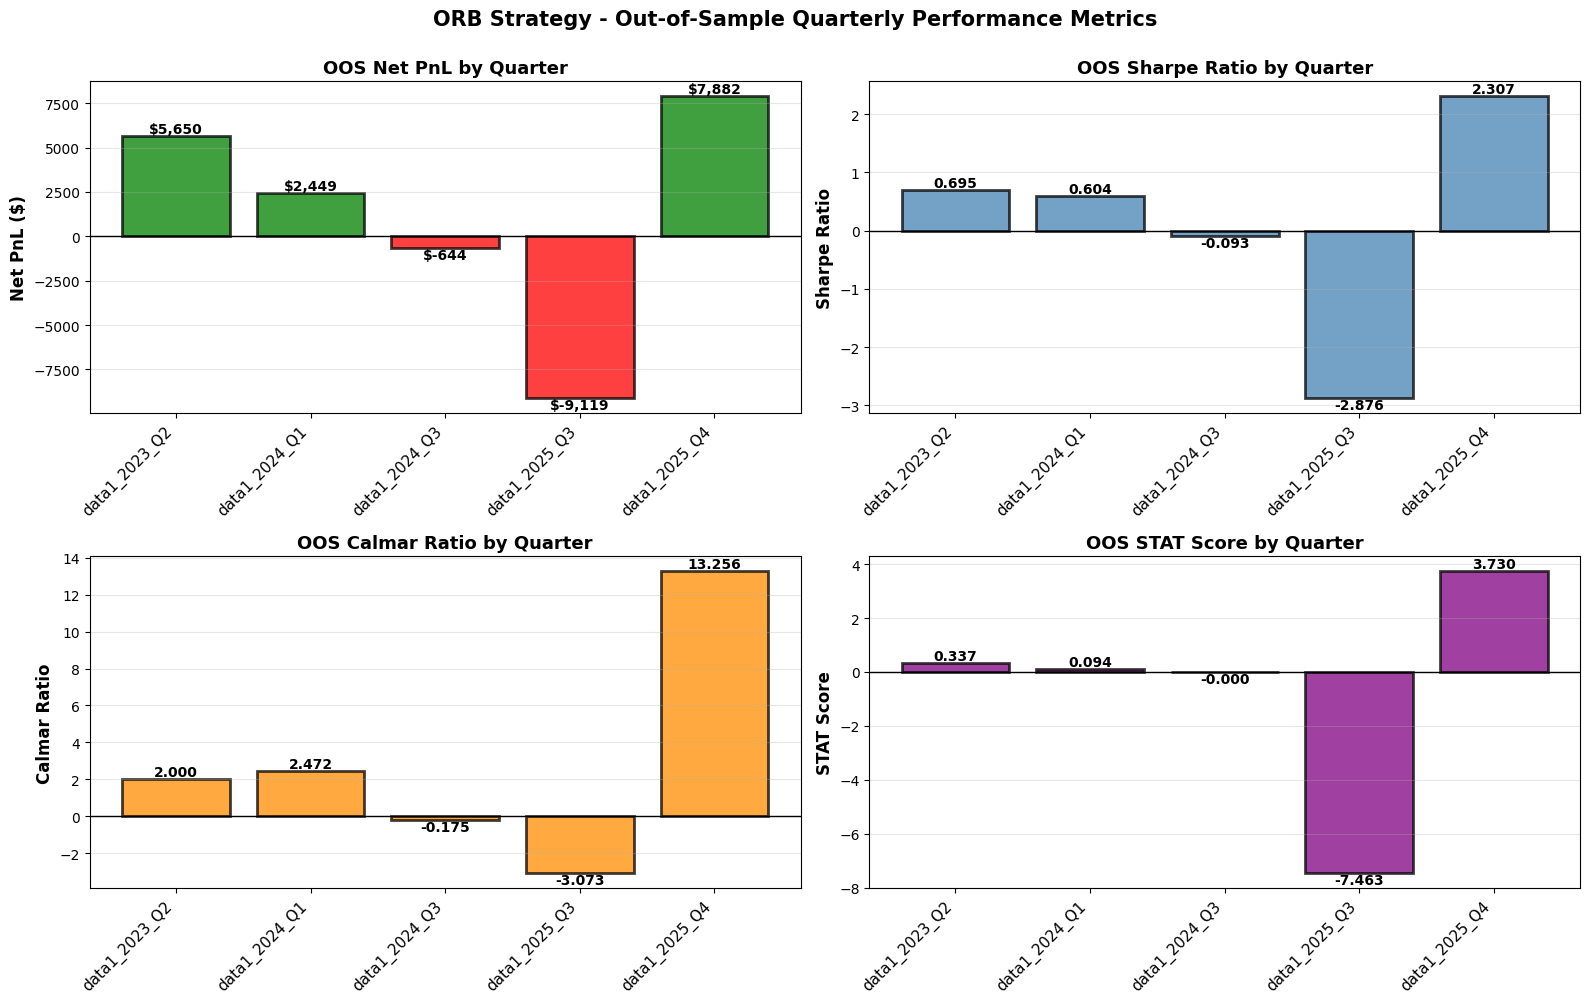

OOS quarterly metrics visualization saved to: outputs_orb_oos_final/oos_quarterly_metrics.png


In [29]:
# Quarterly Performance Comparison for OOS
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

oos_quarters = oos_portfolio_results["quarter"].tolist()
oos_net_pnls = oos_portfolio_results["net_cumPnL"].tolist()
oos_sharpes = oos_portfolio_results["netSR"].tolist()
oos_calmars = oos_portfolio_results["netCR"].tolist()
oos_stats = oos_portfolio_results["stat"].tolist()

# 1. Net PnL by OOS Quarter
ax1 = axes[0, 0]
colors_bars = ['green' if x >= 0 else 'red' for x in oos_net_pnls]
bars1 = ax1.bar(range(len(oos_quarters)), oos_net_pnls, color=colors_bars, alpha=0.75, 
                 edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(oos_quarters)))
ax1.set_xticklabels(oos_quarters, rotation=45, ha='right', fontsize=11)
ax1.axhline(0, color='black', linestyle='-', linewidth=1)
ax1.set_title("OOS Net PnL by Quarter", fontsize=13, fontweight='bold')
ax1.set_ylabel("Net PnL ($)", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, pnl) in enumerate(zip(bars1, oos_net_pnls)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:,.0f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=10)

# 2. Sharpe Ratio by OOS Quarter
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(oos_quarters)), oos_sharpes, color='steelblue', alpha=0.75, 
                 edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(oos_quarters)))
ax2.set_xticklabels(oos_quarters, rotation=45, ha='right', fontsize=11)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title("OOS Sharpe Ratio by Quarter", fontsize=13, fontweight='bold')
ax2.set_ylabel("Sharpe Ratio", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, sharpe in zip(bars2, oos_sharpes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{sharpe:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=10)

# 3. Calmar Ratio by OOS Quarter
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(oos_quarters)), oos_calmars, color='darkorange', alpha=0.75, 
                 edgecolor='black', linewidth=2)
ax3.set_xticks(range(len(oos_quarters)))
ax3.set_xticklabels(oos_quarters, rotation=45, ha='right', fontsize=11)
ax3.axhline(0, color='black', linestyle='-', linewidth=1)
ax3.set_title("OOS Calmar Ratio by Quarter", fontsize=13, fontweight='bold')
ax3.set_ylabel("Calmar Ratio", fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, calmar in zip(bars3, oos_calmars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{calmar:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=10)

# 4. STAT Score by OOS Quarter
ax4 = axes[1, 1]
bars4 = ax4.bar(range(len(oos_quarters)), oos_stats, color='purple', alpha=0.75, 
                 edgecolor='black', linewidth=2)
ax4.set_xticks(range(len(oos_quarters)))
ax4.set_xticklabels(oos_quarters, rotation=45, ha='right', fontsize=11)
ax4.axhline(0, color='black', linestyle='-', linewidth=1)
ax4.set_title("OOS STAT Score by Quarter", fontsize=13, fontweight='bold')
ax4.set_ylabel("STAT Score", fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, stat in zip(bars4, oos_stats):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{stat:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=10)

plt.suptitle("ORB Strategy - Out-of-Sample Quarterly Performance Metrics", 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("outputs_orb_oos_final/oos_quarterly_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"OOS quarterly metrics visualization saved to: outputs_orb_oos_final/oos_quarterly_metrics.png")


## 22. Comprehensive Performance Summary: All Stages (Train/Val/OOS)

In [30]:
# Comprehensive Summary Table
print("\n" + "="*100)
print("COMPREHENSIVE ORB STRATEGY PERFORMANCE SUMMARY - ALL STAGES")
print("="*100)

summary_all_stages = pd.DataFrame({
    "Stage": ["Training", "Validation", "Test", "OOS"],
    "Quarters": [
        f"{len(train_res)} qtrs",
        f"{len(val_res)} qtrs",
        f"{len(test_res)} qtrs",
        f"{len(oos_portfolio_results)} qtrs"
    ],
    "Net PnL": [
        f"${train_metrics['Net PnL']:,.2f}",
        f"${val_metrics['Net PnL']:,.2f}",
        f"${test_metrics['Net PnL']:,.2f}",
        f"${oos_net_pnl:,.2f}"
    ],
    "Avg Sharpe": [
        f"{train_metrics['Avg Sharpe']:.3f}",
        f"{val_metrics['Avg Sharpe']:.3f}",
        f"{test_metrics['Avg Sharpe']:.3f}",
        f"{oos_sharpe:.3f}"
    ],
    "Avg Calmar": [
        f"{train_metrics['Avg Calmar']:.3f}",
        f"{val_metrics['Avg Calmar']:.3f}",
        f"{test_metrics['Avg Calmar']:.3f}",
        f"{oos_calmar:.3f}"
    ],
    "Total STAT": [
        f"{train_metrics['STAT Sum']:.4f}",
        f"{val_metrics['STAT Sum']:.4f}",
        f"{test_metrics['STAT Sum']:.4f}",
        f"{oos_stat:.4f}"
    ]
})

print(summary_all_stages.to_string(index=False))
print("="*100)

# Parameter Verification
print("\n" + "="*100)
print("FINALIZED ORB PARAMETERS (Applied to OOS)")
print("="*100)
params_check = pd.DataFrame({
    "Asset": ["SP", "NQ"],
    "ATR Window": [params_sp["atr_window"], params_nq["atr_window"]],
    "ATR Multiplier": [params_sp["atr_mult"], params_nq["atr_mult"]],
    "Allow Reentry": [params_sp["allow_reentry"], params_nq["allow_reentry"]]
})
print(params_check.to_string(index=False))
print("="*100)

# Key Observations
print("\n" + "="*100)
print("KEY PERFORMANCE OBSERVATIONS")
print("="*100)
print(f"\n1. OVERFITTING CHECK:")
print(f"   - Training Net PnL: ${train_metrics['Net PnL']:,.2f}")
print(f"   - Validation Net PnL: ${val_metrics['Net PnL']:,.2f}")
print(f"   - Test Net PnL: ${test_metrics['Net PnL']:,.2f}")
print(f"   - OOS Net PnL: ${oos_net_pnl:,.2f}")
train_vs_oos_ratio = abs(oos_net_pnl) / abs(train_metrics['Net PnL']) if train_metrics['Net PnL'] != 0 else 0
print(f"   - OOS/Train Ratio: {train_vs_oos_ratio:.2%} (lower indicates potential overfitting)")

print(f"\n2. RISK-ADJUSTED RETURNS:")
print(f"   - Training Sharpe: {train_metrics['Avg Sharpe']:.3f}")
print(f"   - Validation Sharpe: {val_metrics['Avg Sharpe']:.3f}")
print(f"   - Test Sharpe: {test_metrics['Avg Sharpe']:.3f}")
print(f"   - OOS Sharpe: {oos_sharpe:.3f}")

print(f"\n3. DRAWDOWN RISK:")
print(f"   - Training Calmar: {train_metrics['Avg Calmar']:.3f}")
print(f"   - Validation Calmar: {val_metrics['Avg Calmar']:.3f}")
print(f"   - Test Calmar: {test_metrics['Avg Calmar']:.3f}")
print(f"   - OOS Calmar: {oos_calmar:.3f}")

print(f"\n4. OPTIMIZATION OBJECTIVE (STAT Score):")
print(f"   - Training STAT: {train_metrics['STAT Sum']:.4f}")
print(f"   - Validation STAT: {val_metrics['STAT Sum']:.4f}")
print(f"   - Test STAT: {test_metrics['STAT Sum']:.4f}")
print(f"   - OOS STAT: {oos_stat:.4f}")
print("="*100 + "\n")


COMPREHENSIVE ORB STRATEGY PERFORMANCE SUMMARY - ALL STAGES
     Stage Quarters    Net PnL Avg Sharpe Avg Calmar Total STAT
  Training   4 qtrs $30,752.80      1.249      5.299     9.2146
Validation   2 qtrs $19,884.46      1.091      2.628     3.4288
      Test   1 qtrs $20,317.28      1.830      8.627     4.0065
       OOS   5 qtrs  $6,218.61      0.127      2.896    -3.3025

FINALIZED ORB PARAMETERS (Applied to OOS)
Asset  ATR Window  ATR Multiplier  Allow Reentry
   SP          15             0.0          False
   NQ          30             0.2          False

KEY PERFORMANCE OBSERVATIONS

1. OVERFITTING CHECK:
   - Training Net PnL: $30,752.80
   - Validation Net PnL: $19,884.46
   - Test Net PnL: $20,317.28
   - OOS Net PnL: $6,218.61
   - OOS/Train Ratio: 20.22% (lower indicates potential overfitting)

2. RISK-ADJUSTED RETURNS:
   - Training Sharpe: 1.249
   - Validation Sharpe: 1.091
   - Test Sharpe: 1.830
   - OOS Sharpe: 0.127

3. DRAWDOWN RISK:
   - Training Calmar: 5.299
